### Consider a different scalar PDE: Convection-Diffusion equations [Mika Meyer, Kolja Straatman, Pascal Irmer]

Consider the (reaction-)convection-diffusion equation
$$
-\nabla \cdot (\alpha \nabla u) + \beta \cdot \nabla u + \gamma u = f
$$
in $\Omega$, equipped with suitable boundary conditions.

Implement a FEM solver for this problem and carry out numerical experiments to investigate the influence of the convection term on the solution.

Consider the following standard test problem: 
 * Set $ \gamma = 0$, and $\beta = (1,1)$, $\Omega = (0,1)^2$
 * Use homogeneous Dirichlet boundary conditions: $u|_{\partial \Omega} = 0$, see [Dirichlet demo notebook](../demos/dirichlet_2D.ipynb).
 * Consider the so-called mesh Péclét number $Pe = \frac{2 \| \beta \|_\infty}{\gamma h}$, where $h$ is the (initially uniform) mesh size.
 * Take the details as in [this paper, page 19 ff.](https://www.asc.tuwien.ac.at/~schoeberl/wiki/publications/MixedHybridDG.pdf), i.e. take the exact solution and compute (verify) the corresponding r.h.s. and compute the numerical solutions.
 * Implement the (missing) convection integral for $\int_\Omega \beta \cdot \nabla u v \, dx $ in the bilinear form (including tests and notebook(s))
 * Do numerical studies over $h$ and/or $Pe$ with different FE spaces
 * Document the results in proper notebook(s)
 * Use strechted grids (by introducing a mapping in the construction of the mesh) with increasingly small elements towards $x=1$ and $y=1$ and investigate the influence on the solution. (including documentation in notebook(s))

Weak Formulation: $$\int_\Omega \alpha \nabla u \nabla v dx + \int_\Omega  \beta \nabla u v dx +\int_\Omega \gamma u v dx=\int_\Omega fv dx + \int_{\partial\Omega} \alpha \nabla u v ds$$
convection term: $$\int_\Omega  \beta \nabla u v dx$$ [implementation](./formint.py)

In [1]:
from import_hack import *
from methodsnm.mesh_2d import *
from methodsnm.visualize import *
from methodsnm.fes import *
from methodsnm.forms import *
from methodsnm.formint import *
from numpy import pi, cos, sin, arctan, tanh, tan, e

beta=np.array([0,0])
beta1=np.array([1,1])
beta2=np.array([-1,-1])
gamma = 0
alpha = 0.1
N = 5
uh = Solver(N,beta,alpha,gamma,lambda x: 1,function=lambda x,y: (x,y))
uh1 = Solver(N,beta1,alpha,gamma,lambda x: 1,function=lambda x,y: (x,y))
uh2 = Solver(N,beta2,alpha,gamma,lambda x: 1,function=lambda x,y: (x,y))

source module for methodsNM imported.


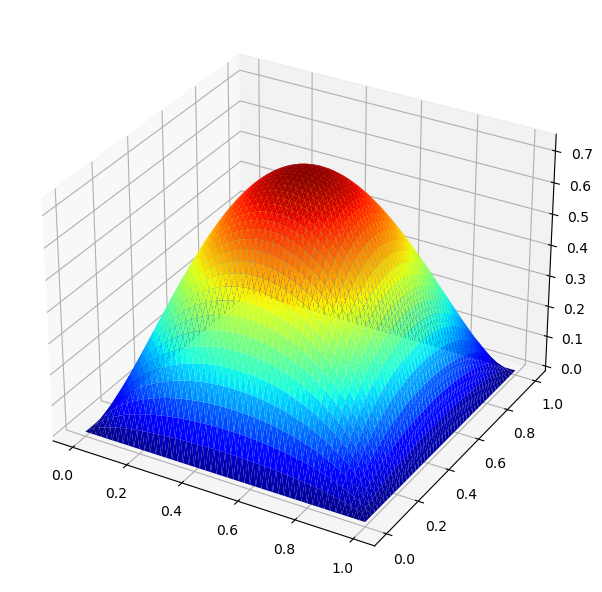

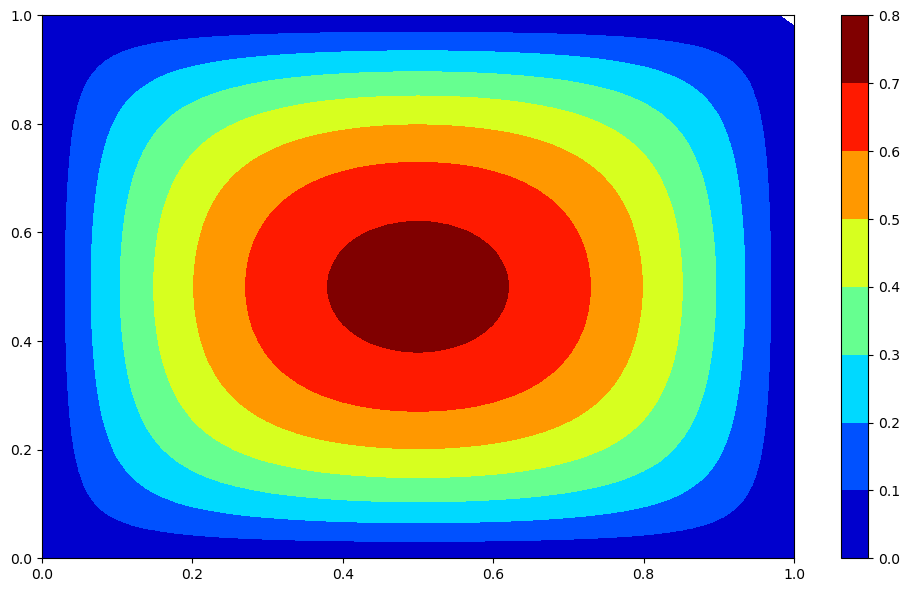

In [2]:
DrawFunction2D(uh, contour=False)
DrawFunction2D(uh, contour=True)

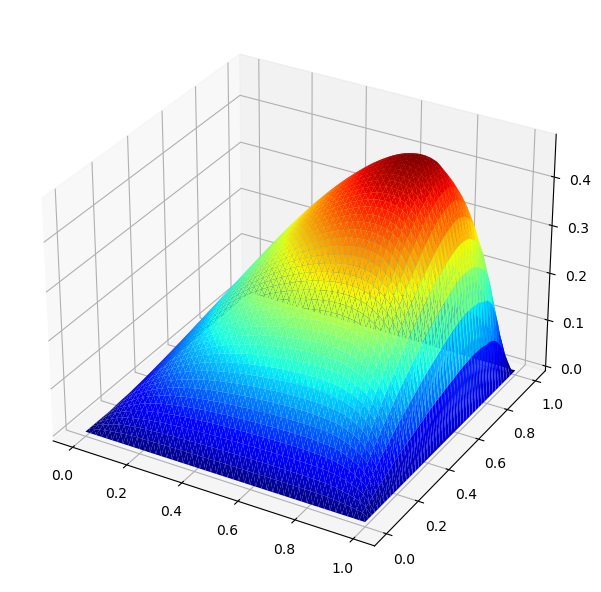

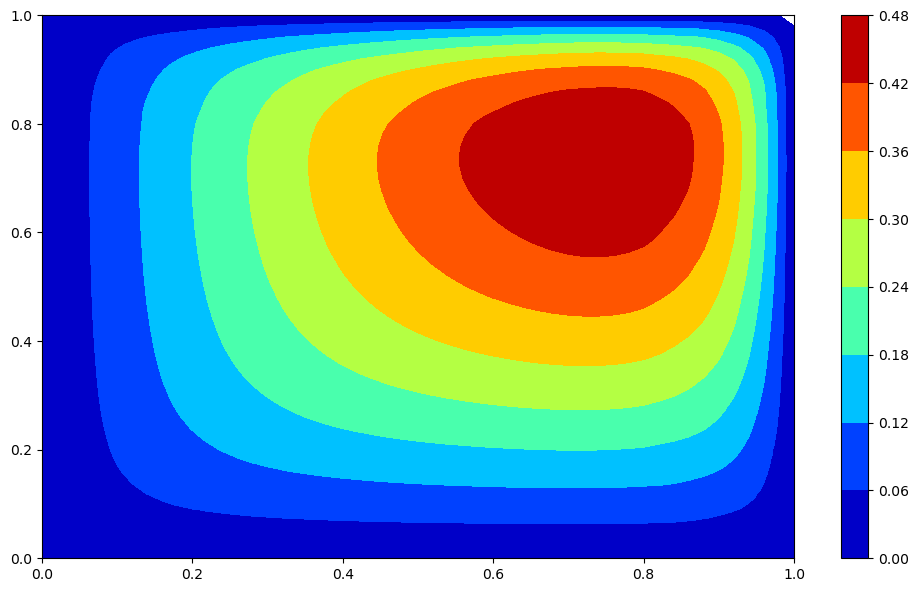

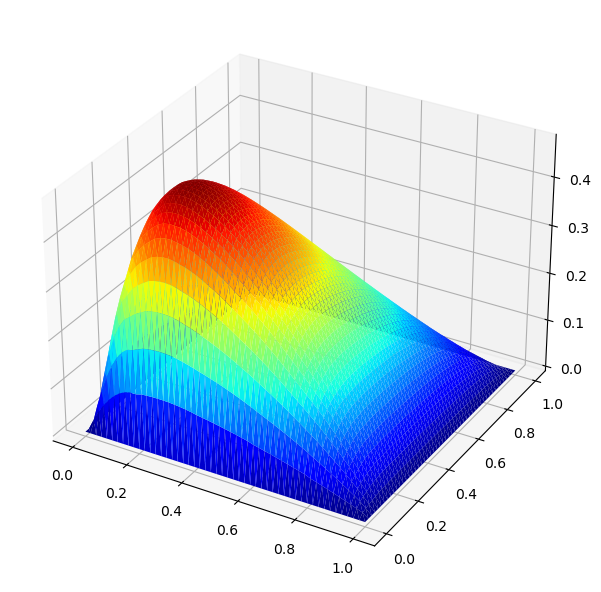

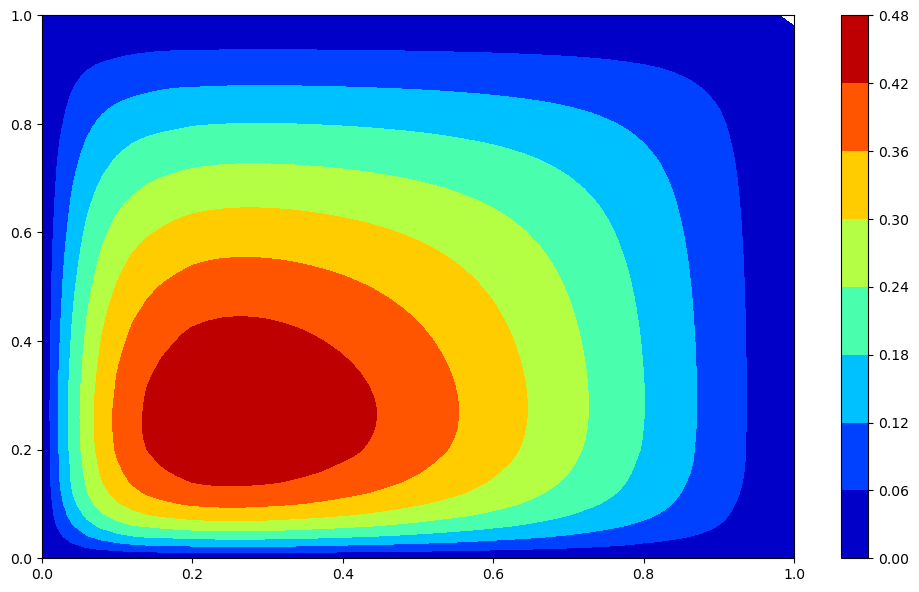

In [3]:
DrawFunction2D(uh1, contour=False)
DrawFunction2D(uh1, contour=True)
DrawFunction2D(uh2, contour=False)
DrawFunction2D(uh2, contour=True)

Right hand side $$f(x,y)=\beta_1\left(y + \frac{e^\frac{\beta_2y}{\alpha} - 1}
                 {1 - e^\frac{\beta_2}{\alpha}}\right) + 
        \beta_2\left(x + \frac{e^\frac{\beta_1x}{\alpha} - 1}
                 {1 - e^\frac{\beta_1}{\alpha}}\right)$$

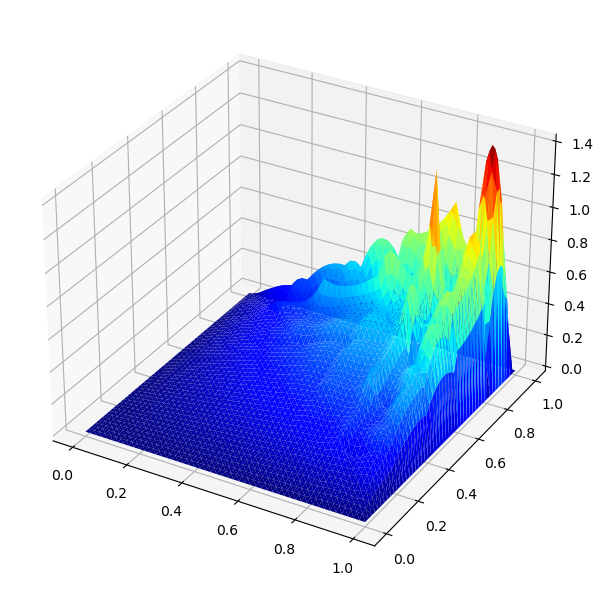

In [33]:
beta=np.array([1,1])
conv_diff = lambda x: \
        beta[0]*(x[1] + (e**(beta[1]*x[1]/alpha) - 1)/
                 (1 - e**(beta[1]/alpha))) + \
        beta[1]*(x[0] + (e**(beta[0]*x[0]/alpha) - 1) /
                 (1 - e**(beta[0]/alpha)))
alpha = 0.01
uh = Solver(N,beta=beta,alpha=alpha,gamma=gamma, rs=conv_diff, function=lambda x,y: (x,y))

DrawFunction2D(uh, contour=False)
#DrawFunction2D(uh, contour=True)

Exact solution

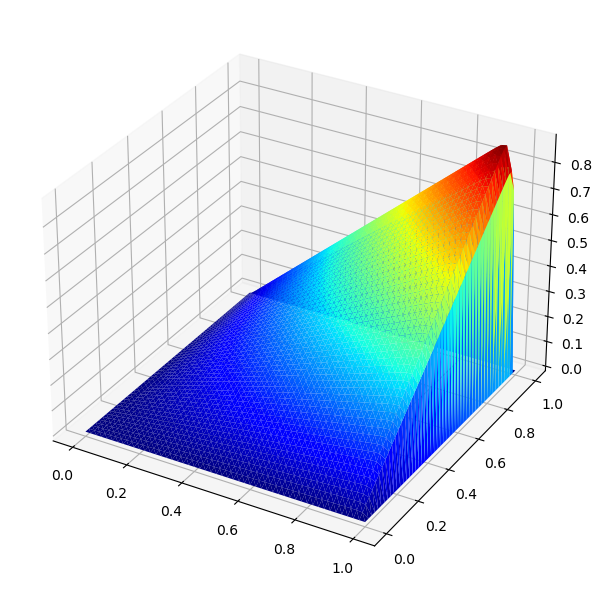

0.06534684781813672

In [34]:
mesh= StructuredRectangleMesh(N, N)
u_exact = GlobalFunction(lambda x: (x[0]+(np.exp(beta[0]*x[0]/alpha)-1)/(1-np.exp(beta[0]/alpha)))*(x[1]+(np.exp(beta[1]*x[1]/alpha)-1)/(1-np.exp(beta[1]/alpha))), mesh=mesh)
DrawFunction2D(u_exact)
#DrawFunction2D(u_exact, contour=True) 
error_calc(uh, u_exact)

Stretching

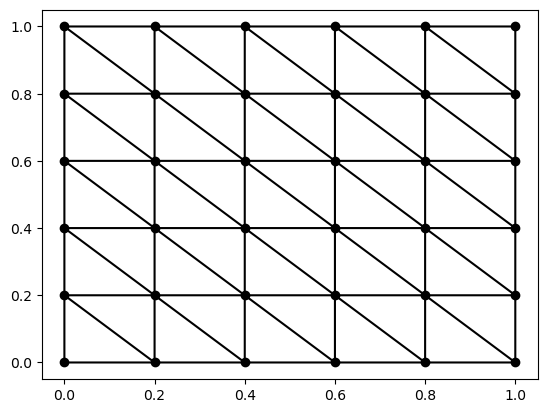

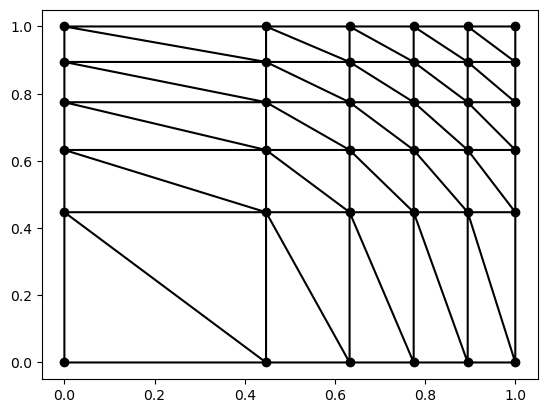

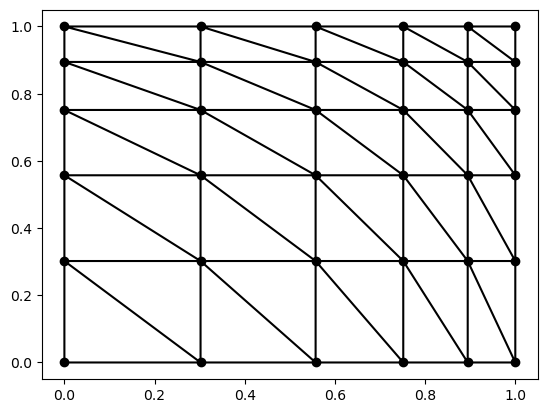

In [17]:
mesh= StructuredRectangleMesh(N, N)
mesh_mod = StructuredRectangleMesh(N, N,mapping= lambda x,y: (x**0.5, y**0.5))
mesh_mod1 = StructuredRectangleMesh(N, N, mapping= lambda x,y: (arctan(tan(1)*x), arctan(tan(1)*y)))
h =1/N
DrawMesh2D(mesh)
DrawMesh2D(mesh_mod)
DrawMesh2D(mesh_mod1)

The Péclét number (Pe) is defined by the ratio of the rate of advection of a physical quantity by the flow to the rate of diffusion of the same quantity driven by an appropriate gradient.
$$\mathrm{Pe}=\frac{\mathrm{addvective}\,\, \mathrm{transport}\,\, \mathrm{rate}}{\mathrm{diffusive}\,\, \mathrm{transport}\,\, \mathrm{rate}}=\frac{2\Vert \beta \Vert_\infty}{\alpha h}$$

In [24]:
beta_max = beta.flat[np.abs(beta).argmax()]
beta_max = np.linalg.norm(beta, ord=np.inf)
Pec = 2*beta_max /(alpha*h)
print("Péclét number:", Pec)

Péclét number: 1000.0


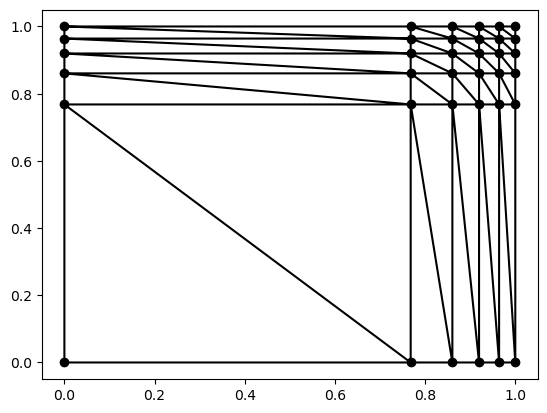

In [27]:
alpha=0.01
def a(alpha):
    if alpha>=1:
        return 1
    else:
        return (alpha * (e ** (-(alpha-1))))**0.5
        #mesh = StructuredRectangleMesh(N, N, mapping=lambda x, y: (np.arctan(tan(1)*x)**a(alpha), np.arctan(tan(1)*y)**a(alpha)))
mesh1 = StructuredRectangleMesh(N, N, mapping=lambda x, y: (x**a(alpha), y**a(alpha)))
DrawMesh2D(mesh1)

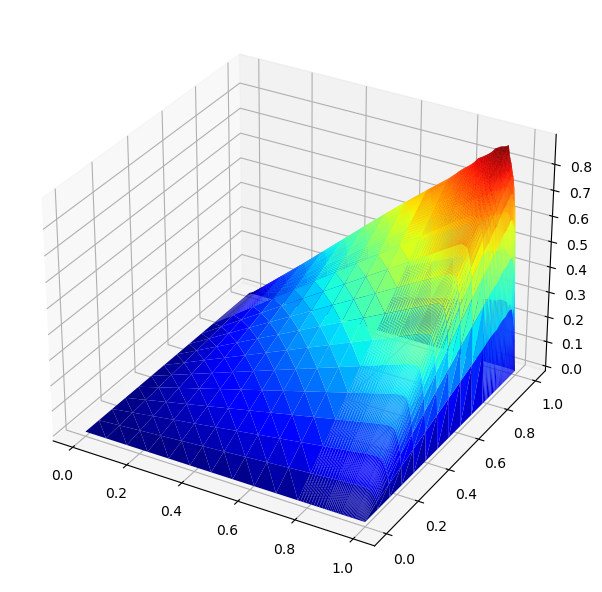

In [29]:
uh = Solver(N,beta=beta,alpha=alpha,gamma=gamma, rs=conv_diff, function=lambda x, y: (x**a(alpha), y**a(alpha)))
DrawFunction2D(uh)

In [35]:
print("Error:",error_calc(uh, u_exact))

Error: 0.06534684781813672


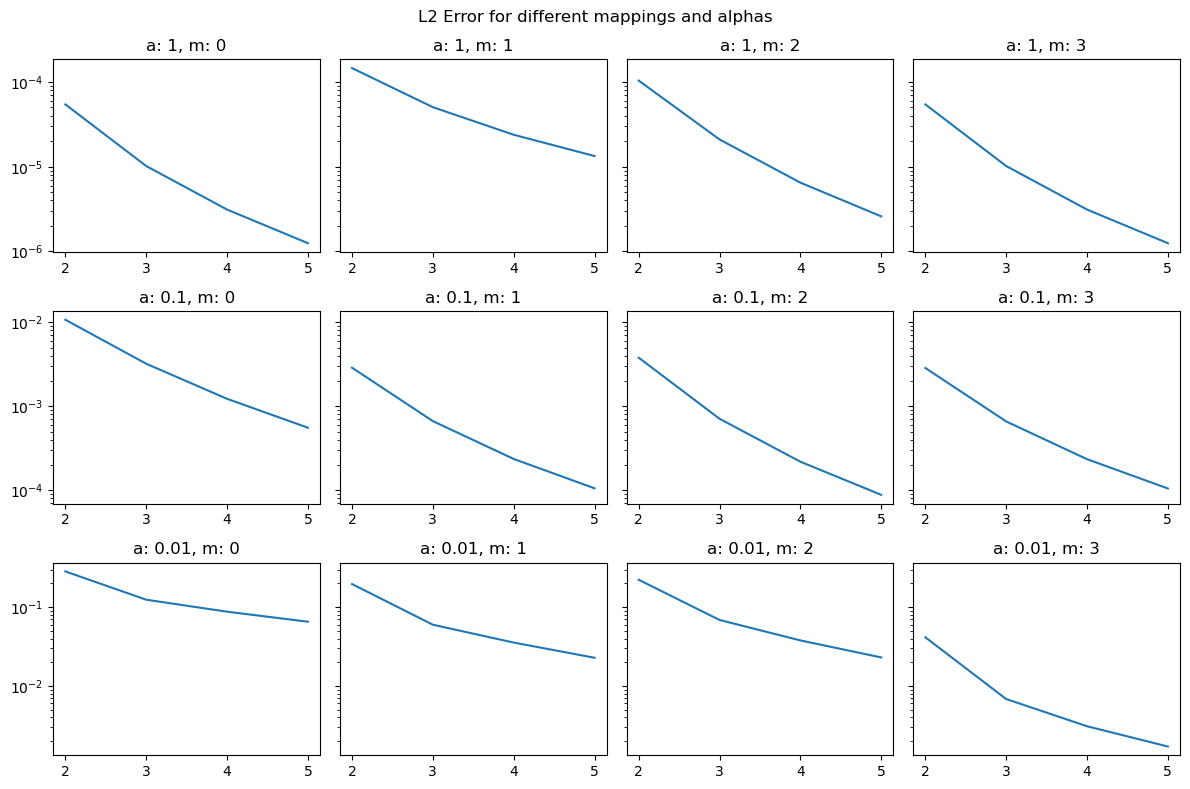

In [54]:
N_list = [2, 3, 4, 5, 6, 8, 10]
alphas_list = [1, 0.1, 0.01]
mappings_list = [lambda x, y: (x, y), lambda x, y: (x**0.5, y**0.5),
                 lambda x, y: (np.arctan(tan(1)*x), np.arctan(tan(1)*y)), lambda x,y,alpha: (x**a(alpha), y**a(alpha))]
fig, axs = plt.subplots(len(alphas_list), len(mappings_list), sharey="row", figsize=(12,8))
error=np.zeros((len(N_list),len(alphas_list),len(mappings_list)))
for k, N in enumerate(N_list):
    for j, alpha in enumerate(alphas_list):
        for i in range(len(mappings_list)-1):
            error[k,j,i]=error_calc(Solver(N,beta=beta,alpha=alpha,gamma=gamma, rs=conv_diff, function=mappings_list[i]),u_exact)
            
        error[k,j,-1]=error_calc(Solver(N,beta=beta,alpha=alpha,gamma=gamma, rs=conv_diff, function=lambda x,y: (x**a(alpha), y**a(alpha))),u_exact)
        
for i, df in enumerate(mappings_list):
    for j in range(len(alphas_list)):
        axs[j][i].set_yscale("log")
        axs[j][i].plot(N_list, error[:,j,i])
        axs[j][i].set_title(f"a: {alphas_list[j]}, m: {i}")

fig.suptitle('L2 Error for different mappings and alphas')
plt.tight_layout()
plt.show()
